In [208]:
from langgraph.graph import StateGraph, START, END
from langchain.agents import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage, AIMessage
from typing import List, TypedDict
from langchain.vectorstores import Qdrant
from qdrant_client import QdrantClient
from IPython.display import Image, display
from langchain.embeddings import OpenAIEmbeddings
from langchain.tools import tool
from serpapi import GoogleSearch
import os
from langchain_community.tools import TavilySearchResults
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.document_loaders import WikipediaLoader



In [209]:
from dotenv import load_dotenv
import os 
load_dotenv('.env')

True

In [210]:
import operator
from typing import Annotated
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
llm = ChatOpenAI(model="gpt-4o")

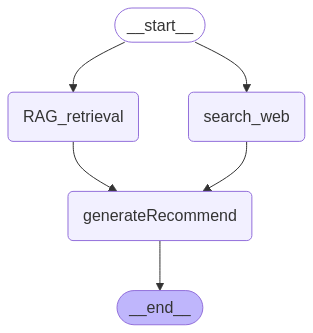

In [211]:
class RecommendState(TypedDict):
    query: str
    answer: str
    context: Annotated[list, operator.add]
def RAG_retrieval(state):
    """ Recommend hotels, restaurants based on user input """
    client = QdrantClient(host="localhost", port=6333)
    embeddings = OpenAIEmbeddings()
    
    # Load vectorstore từ collection đã tồn tại
    vectorstore = Qdrant(
        client=client,
        collection_name="hotels_and_restaurants",
        embeddings=embeddings
    )
    context_items = vectorstore.similarity_search(state["query"], k=10)
    # Lấy nội dung của các tài liệu
    context_text = "\n".join(
        doc.page_content if hasattr(doc, "page_content") else str(doc)
        for sublist in context_items
        for doc in (sublist if isinstance(sublist, list) else [sublist])
    )
    return {"context": [context_text]}
def search_web(state):
    
    """ Retrieve docs from web search about everything related to tourism """

    # Search
    tavily_search = TavilySearchResults(max_results=5)
    search_docs = tavily_search.invoke(state['query'])
     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formatted_search_docs]} 
def generateRecommend(state):
    """ Generate a recommendation based on the context """
    context = "\n\n".join(str(item) for item in state["context"])
    query = state["query"]
    prompt_template = """
Bạn là một chuyên gia du lịch và có kiến thức đầy đủ về các khách sạn tại Việt Nam. Bạn hãy trả lời câu hỏi của tôi dựa trên thông tin mà tôi đã cung cấp cho bạn. Các câu hỏi chủ yếu về các địa điểm du lịch, và cách xây dựng tour du lịch hợp lí bao gồm khách sạn, nhà hàng cũng như các địa điểm du lịch nổi tiếng gần đó.
Dưới đây là thông tin về một khách sạn mà tôi đã tìm thấy: {context}

Hãy cung cấp thông tin chi tiết về khách sạn, nhà hàng và tour du lịch theo như tôi yêu cầu, sử dụng các thông tin đã có và bổ sung thêm nếu có. Nếu có các thông tin về đường dẫn tới map hay facebook, website của khách sạn hay nhà hàng, hãy cung cấp cho tôi. Nếu không có thông tin nào, hãy nói là không có thông tin nào.
"""
    answer_instructions = prompt_template.format(context=context)
    response = llm.invoke([SystemMessage(content=answer_instructions)] + [HumanMessage(content=f"Trả lời các câu hỏi sau {query}")])
    return {"answer": response}
    
rs_builder = StateGraph(RecommendState)
rs_builder.add_node("RAG_retrieval", RAG_retrieval)
rs_builder.add_node("search_web", search_web)
rs_builder.add_node("generateRecommend", generateRecommend)

rs_builder.add_edge(START, "RAG_retrieval")
rs_builder.add_edge(START, "search_web")
rs_builder.add_edge("RAG_retrieval", "generateRecommend")
rs_builder.add_edge("search_web", "generateRecommend")
rs_builder.add_edge("generateRecommend", END)
rs_graph = rs_builder.compile()

display(Image(rs_graph.get_graph().draw_mermaid_png()))

In [212]:
result = rs_graph.invoke({"query": "Tìm các khách san ở Đà Nẵng có view biển và gần các địa điểm du lịch nổi tiếng"})
result['answer'].content

'Dưới đây là danh sách một số khách sạn ở Đà Nẵng có view biển và gần các địa điểm du lịch nổi tiếng:\n\n1. **Mường Thanh Luxury Đà Nẵng**:\n   - Địa chỉ: Bên bờ biển Mỹ Khê, Đà Nẵng.\n   - Mô tả: Khách sạn 5 sao với không gian sang trọng, chỉ cần đi bộ vài bước để đến bãi biển Mỹ Khê. Gần sân bay Đà Nẵng (5,5 km) và ga Đà Nẵng (5 km).\n   - Gần các điểm du lịch nổi tiếng của thành phố.\n\n2. **Sala Danang Beach Hotel**:\n   - Địa chỉ: Bên bãi biển Mỹ Khê.\n   - Mô tả: Nằm cách trung tâm thành phố và Cầu Sông Hàn chỉ tầm 2km. Khách sạn 4 sao cung cấp 162 phòng với tầm view hướng biển thơ mộng.\n   - Link thông tin: [Sala Danang Beach Hotel](https://vietgoing.com/top/44-top-14-khach-san-da-nang-view-bien-dep-nhu-mo.html)\n\n3. **Cicilia Danang Hotel & Spa**:\n   - Địa chỉ: Gần bãi biển Mỹ Khê.\n   - Mô tả: Khách sạn 4 sao, cách cầu sông Hàn 3.19km. Nổi bật với kiến trúc sang trọng và hiện đại.\n   - Link thông tin: [Cicilia Danang Hotel & Spa](https://www.traveloka.com/vi-vn/explore/act

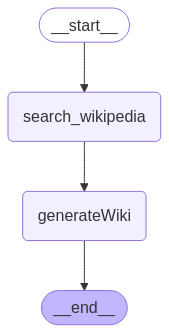

In [213]:
class WikiState(TypedDict):
    query: str
    context: Annotated[list, operator.add]
    answer: str
def search_wikipedia(state):
    
    """ Retrieve docs from wikipedia """

    # Search
    search_docs = WikipediaLoader(query=state['query'], 
                                  load_max_docs=6).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formatted_search_docs]}     
def generateWiki(state):
    """ Generate a recommendation based on the context """
    query = state["query"]
    context = state["context"]
    prompt_template = """
Bạn là một chuyên gia trả lời câu hỏi có sẵn từ wikipedia. Bạn đã nhận được dữ liệu từ wikipedia như sau: {context}

Hãy phân tích, tổng hợp để trả lời câu hỏi của người dùng."""
    answer_instructions = prompt_template.format(context=context)
    response = llm.invoke([SystemMessage(content=answer_instructions)] + [HumanMessage(content=f"Trả lời các câu hỏi sau {query}")])
    return {"answer": response}
    
ws_builder = StateGraph(WikiState)
ws_builder.add_node("search_wikipedia", search_wikipedia)
ws_builder.add_node("generateWiki", generateWiki)
ws_builder.add_edge(START, "search_wikipedia")
ws_builder.add_edge("search_wikipedia", "generateWiki")
ws_builder.add_edge("generateWiki", END)
ws_graph = ws_builder.compile()
display(Image(ws_graph.get_graph().draw_mermaid_png()))

In [214]:
result = ws_graph.invoke({"query": "Đà Nẵng có những gì nổi tiếng"})
print(result['answer'].content)

Đà Nẵng là một thành phố nổi tiếng ở Việt Nam với nhiều điểm đặc biệt đáng chú ý:

1. **Vị trí địa lý và cảng biển quan trọng**: Đà Nẵng nằm trên bờ biển Nam Trung Bộ của Việt Nam và là một trong những cảng biển quan trọng nhất của quốc gia này.

2. **Điểm du lịch nổi tiếng**: Đà Nẵng gần với nhiều di sản thế giới UNESCO như Cố đô Huế, phố cổ Hội An và thánh địa Mỹ Sơn, thu hút nhiều du khách quốc tế.

3. **Phát triển kinh tế và giáo dục**: Đây là trung tâm thương mại và giáo dục của miền Trung Việt Nam, với hạ tầng giao thông và cảng biển phát triển tốt.

4. **Sự kiện APEC 2017**: Đà Nẵng từng là nơi đăng cai tổ chức Hội nghị thượng đỉnh APEC vào năm 2017.

5. **Chất lượng cuộc sống và chỉ số phát triển con người cao**: Thành phố có chỉ số phát triển con người cao (0.800), xếp hạng cao thứ năm ở Việt Nam.

Đà Nẵng cũng nổi tiếng với các cây cầu ấn tượng, bãi biển Mỹ Khê xinh đẹp và hoạt động du lịch sôi động.


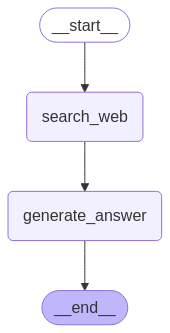

In [215]:
class SearchState(TypedDict):
    query: str
    context: Annotated[list, operator.add]
    answer: str

def search_web(state):
    """ Retrieve docs from web search about everything """
    # Search
    tavily_search = TavilySearchResults(max_results=5)
    search_docs = tavily_search.invoke(state['query'])
     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
    print(type(formatted_search_docs))
    
def generate_answer(state):
    """ Generate a recommendation based on the context """
    query = state["query"]
    context = state["context"]
    prompt_template = """
Bạn là một chuyên gia trả lời câu hỏi có sẵn từ google. Bạn đã nhận được dữ liệu từ google như sau: {context}"""
    answer_instructions = prompt_template.format(context=context)
    response = llm.invoke([SystemMessage(content=answer_instructions)] + [HumanMessage(content=f"Trả lời các câu hỏi sau {query}")])
    return {"answer": response}
search_builder = StateGraph(SearchState)
search_builder.add_node("search_web", search_web)
search_builder.add_node("generate_answer", generate_answer)
search_builder.add_edge(START, "search_web")
search_builder.add_edge("search_web", "generate_answer")
search_builder.add_edge("generate_answer", END)
search_graph = search_builder.compile()
display(Image(search_graph.get_graph().draw_mermaid_png()))

In [223]:
result = ws_graph.invoke({"query": "Có nên đi chơi Vinhomes Ocean Park không?"})
print(result['answer'].content)

Vinhomes Ocean Park là một khu đô thị đa chức năng nằm ở Gia Lâm, Hà Nội. Dưới đây là một số lý do mà bạn có thể cân nhắc để đến thăm nơi này:

1. **Kiến trúc và phong cảnh**: Vinhomes Ocean Park được thiết kế với cảnh quan đẹp mắt, bao gồm hồ lớn và các khu vực cây xanh, đường dạo bộ. Điều này phù hợp cho những ai yêu thích chụp ảnh hoặc thư giãn trong không gian thoáng đãng.

2. **Tiện ích đa dạng**: Khu đô thị này có nhiều tiện ích hiện đại như khu vui chơi giải trí, khu mua sắm, các nhà hàng, quán cà phê và công viên nước, đáp ứng nhu cầu giải trí của nhiều lứa tuổi.

3. **Hoạt động ngoài trời**: Vinhomes Ocean Park thường tổ chức nhiều sự kiện và hoạt động ngoài trời, từ các trò chơi dưới nước đến các sự kiện văn hóa, thích hợp cho các gia đình hoặc nhóm bạn.

4. **Giao thông thuận tiện**: Từ trung tâm Hà Nội, bạn có thể dễ dàng di chuyển đến đây bằng ô tô hoặc xe máy qua các tuyến đường lớn.

Việc có nên đi chơi Vinhomes Ocean Park hay không phụ thuộc vào sở thích cá nhân và nhữn

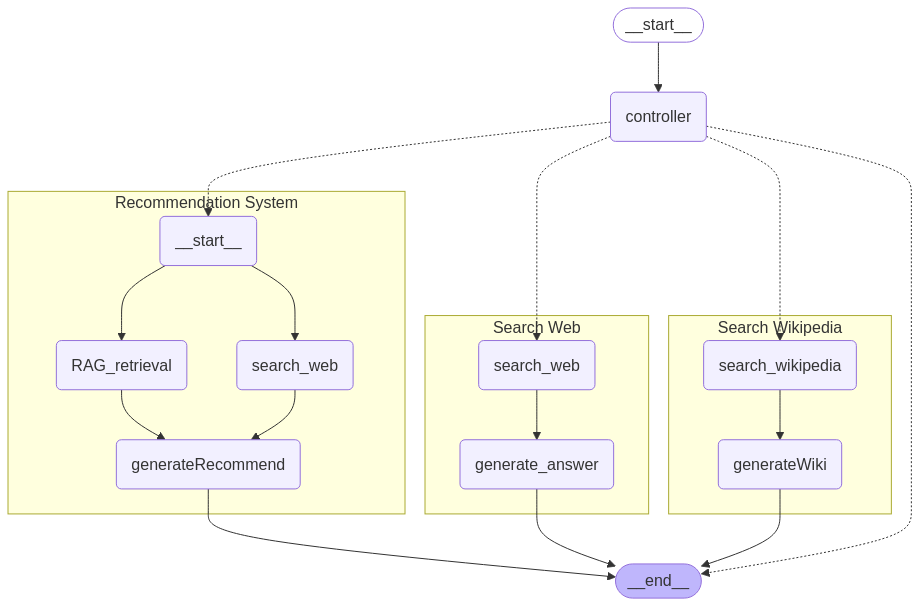

In [230]:
class EntryGraphState(TypedDict):
    query: str
    context: Annotated[list, operator.add]
    answer: str
    subgraph_name: str
    
def controller(state):
    """ Controller to decide which subgraph to use """
    prompt_template = """Bạn là một chuyên gia dự đoán các câu hỏi của người dùng,
    dựa trên câu hỏi của người dùng, hãy quyết định subgraph nào nên được kích hoạt để Agent có thể 
    đưa ra câu trả lời tốt nhất cho người dùng.
    Hãy trả lời với một trong các subgraph sau: `Recommendation System`, `Search Wikipedia` và `Search Web`.
    LƯU Ý: CHỈ ĐƯA RA MỘT TRONG CÁC GIÁ TRỊ NÀY, KHÔNG ĐƯA RA CÁC GIÁ TRỊ KHÁC.
    Hãy đưa ra câu trả lời ngắn gọn và súc tích.
    Đây là câu hỏi của người dùng: {query}"""
    messages = llm.invoke(prompt_template.format(query=state["query"]))
    if messages.content == "Recommendation System":
        return {"subgraph_name": "Recommendation System"}
    elif messages.content == "Search Wikipedia":
        return {"subgraph_name": "Search Wikipedia"}
    elif messages.content == "Search Web":
        return {"subgraph_name": "Search Web"}
    return {"subgraph_name": "Search Web"}

def condition_tools(state):
    if state['subgraph_name'] == "Recommendation System":
        return "Recommendation System"
    elif state['subgraph_name'] == "Search Wikipedia":
        return "Search Wikipedia"
    elif state['subgraph_name'] == "Search Web":
        return "Search Web"
    else:
        return "Search Web"
    
builder = StateGraph(EntryGraphState)
builder.add_node("controller", controller)
builder.add_node("Recommendation System", rs_builder.compile())
builder.add_node("Search Wikipedia", ws_builder.compile())
builder.add_node("Search Web", search_builder.compile())

builder.add_edge(START, "controller")
builder.add_conditional_edges(
    "controller",
    condition_tools
)
builder.add_edge("Recommendation System", END)
builder.add_edge("Search Wikipedia", END)
builder.add_edge("Search Web", END)
graph = builder.compile()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
result = graph.invoke({"query": "Cho tôi một gợi ý tour đi du lịch Sapa"})
print(result['answer'].content)

Dưới đây là một gợi ý về lịch trình tour 3 ngày 2 đêm tại Sapa, bao gồm các hoạt động tham quan, khách sạn và các nhà hàng:

**Ngày 1: Hà Nội - Sapa**
- **Khởi hành từ Hà Nội:** Bạn có thể lựa chọn đi xe giường nằm hoặc tàu hỏa để tới Sapa.
- **Đến Sapa check-in khách sạn:** 
  - Tham khảo Khách sạn My Boutique Sapa hoặc Sapa Nature View Hotel. Cả hai đều có tiện nghi hiện đại như Lễ tân 24h, Wifi miễn phí, Bể bơi ngoài trời, Ban công/Cửa sổ và có mức giá hợp lý.
- **Ăn trưa tại nhà hàng địa phương:**
  - Mộc Takeaway trên Bản Cát Cát, Xã Hoàng Liên Sapa. (Mở cửa 10:00 AM - 6:00 PM).
- **Chiều:** Tham quan núi Hàm Rồng và khu vực trung tâm thị trấn Sapa.

**Ngày 2: Khám Phá Sapa**
- **Sáng:** Đi cáp treo lên đỉnh Fansipan - "Nóc nhà Đông Dương". 
- **Ăn trưa:** 
  - Nhà hàng Gem Valley, Cat Cat - Sapa. Thưởng thức bữa trưa giữa phong cảnh thiên nhiên tuyệt đẹp.
- **Chiều:** Tham quan Bản Cát Cát, trải nghiệm văn hóa người H'mông.
- **Tối:** 
  - Ăn tối tại The Haven Sapa Restaurant, 80